# DQN vs. DSQN for the CartPole Environment

In [2]:
import os
import gym
import site
import torch
import random

import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

site.addsitedir('../src/')

from datetime import date
from model import QNetwork, DSNN
from dqn_agent import Agent, ReplayBuffer
from matplotlib.gridspec import GridSpec

%matplotlib inline

In [3]:
# Environment specific parameters
env_name = 'CartPole-v0'
n_runs = 5
n_evaluations = 100
max_steps = 200
num_episodes = 500

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Create Results Directory
dirs = os.listdir('.')
if not any('result' in d for d in dirs):
    result_id = 1
else:
    results = [d for d in dirs if 'result' in d]
    result_id = len(results) + 1

# Get today's date and add it to the results directory
d = date.today()
result_dir = 'dqn_result_' + str(result_id) + '_{}'.format(
    str(d.year) + str(d.month) + str(d.day))
os.mkdir(result_dir)
print('Created Directory {} to store the results in'.format(result_dir))

Created Directory dqn_result_1_2023628 to store the results in


In [5]:
# Hyperparameters
batch_size = 128
discount_factor = 0.999
eps_start = 1.0
eps_end = 0.05
eps_decay = 0.999
update_every = 4
target_update_frequency = 100
learning_rate = 0.001
replay_memory_size = 4*10**4
tau = 1e-3

In [6]:
# SNN Hyperparameters
simulation_time = 3
alpha = 0.5
beta = 0.5
threshold = 0.2
weight_scale = 1
architecture = [4, 64, 64, 2]

In [7]:
seeds = np.load('../seeds/training_seeds.npy')

## DQN Training

In [8]:
smoothed_scores_dqn_all = []
dqn_completion_after = []

for i_run in range(n_runs):
    print("Run # {}".format(i_run))
    seed = int(seeds[i_run])
    
    torch.manual_seed(seed)
    random.seed(seed)

    policy_net = QNetwork(architecture, seed).to(device)
    target_net = QNetwork(architecture, seed).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    agent = Agent(env_name, policy_net, target_net, architecture, batch_size,
                  replay_memory_size, discount_factor, eps_start, eps_end, eps_decay,
                  update_every, target_update_frequency, optimizer, learning_rate,
                  num_episodes, max_steps, i_run, result_dir, seed, tau)
    
    smoothed_scores, scores, best_average, best_average_after = agent.train_agent()

    np.save(result_dir + '/scores_{}'.format(i_run), scores)
    np.save(result_dir + '/smoothed_scores_DQN_{}'.format(i_run), smoothed_scores)

    # save smoothed scores in list to plot later
    dqn_completion_after.append(best_average_after)
    smoothed_scores_dqn_all.append(smoothed_scores)
    print("")

Run # 0


c:\Users\maxim\Anaconda3\envs\drl\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Episode 100	Average Score: 22.52	 Epsilon: 0.11
Episode 200	Average Score: 179.29	 Epsilon: 0.05
Episode 300	Average Score: 198.86	 Epsilon: 0.05
Episode 400	Average Score: 200.00	 Epsilon: 0.05
Episode 500	Average Score: 199.90	 Epsilon: 0.05
Best 100 episode average:  200.0  reached at episode  317 . Model saved in folder best.

Run # 1
Episode 100	Average Score: 34.97	 Epsilon: 0.05
Episode 200	Average Score: 178.80	 Epsilon: 0.05
Episode 300	Average Score: 199.26	 Epsilon: 0.05
Episode 400	Average Score: 200.00	 Epsilon: 0.05
Episode 500	Average Score: 200.00	 Epsilon: 0.05
Best 100 episode average:  200.0  reached at episode  342 . Model saved in folder best.

Run # 2
Episode 100	Average Score: 23.04	 Epsilon: 0.10
Episode 200	Average Score: 162.73	 Epsilon: 0.05
Episode 300	Average Score: 195.89	 Epsilon: 0.05
Episode 400	Average Score: 112.31	 Epsilon: 0.05
Episode 500	Average Score: 162.09	 Epsilon: 0.05
Best 100 episode average:  200.0  reached at episode  343 . Model saved in

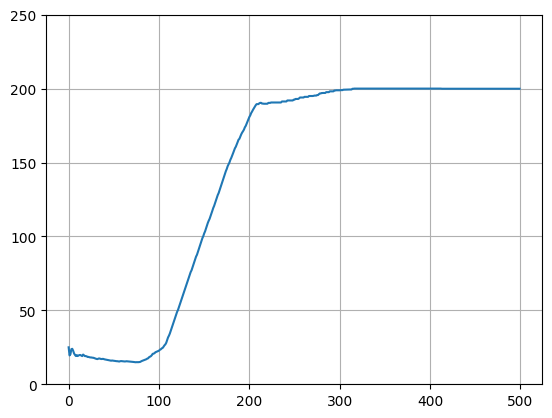

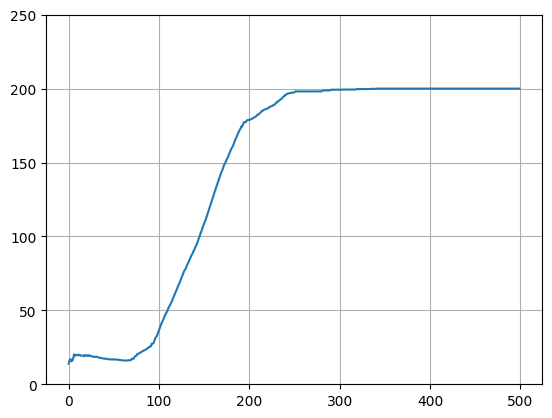

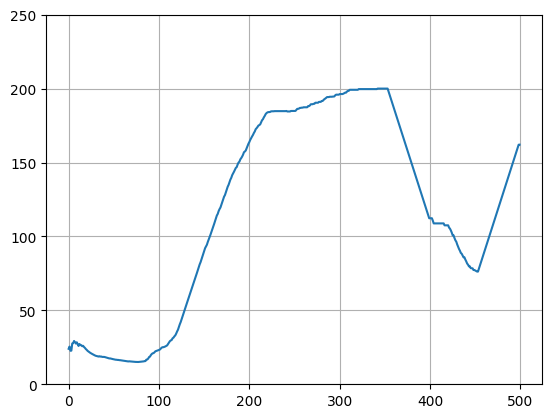

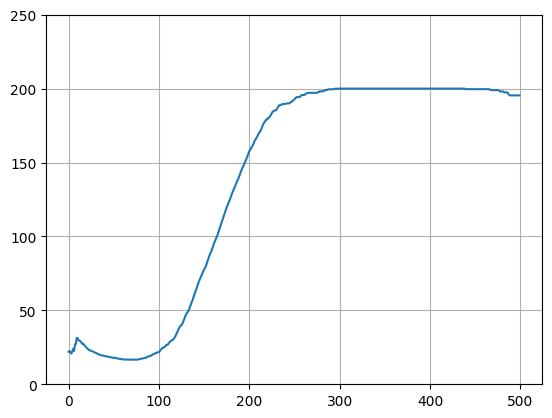

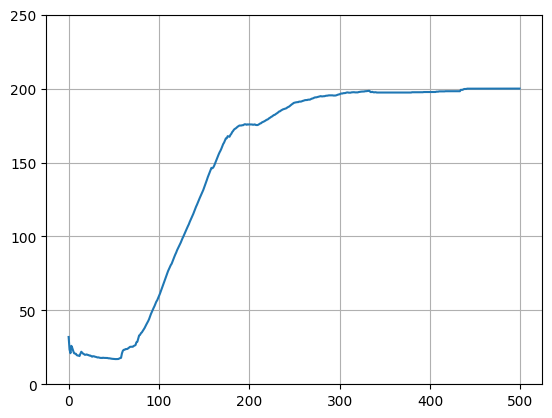

In [9]:
# Plot scores of individual runs
for i in range(len(smoothed_scores_dqn_all)):
    fig = plt.figure()
    plt.plot(smoothed_scores_dqn_all[i])
    plt.ylim(0, 250)
    plt.grid(True)
    plt.savefig(result_dir + '/training_dqn_{}.png'.format(i), dpi=1000)
    plt.show()

In [ ]:
# Plot results (mean)
best_smoothed_scores_dqn = [smoothed_scores_dqn_all[0],
                            smoothed_scores_dqn_all[1],
                            smoothed_scores_dqn_all[2],
                            smoothed_scores_dqn_all[3],
                            smoothed_scores_dqn_all[4]]
mean_smoothed_scores_dqn = np.mean(best_smoothed_scores_dqn, axis=0)
std_smoothed_scores = np.std(best_smoothed_scores_dqn, axis=0)

avg_dqn_completion_after = np.mean([dqn_completion_after[0],
                                    dqn_completion_after[1],
                                    dqn_completion_after[2],
                                    dqn_completion_after[3],
                                    dqn_completion_after[4]])

fig = plt.figure()
plt.plot(range(len(best_smoothed_scores_dqn[0])), mean_smoothed_scores_dqn)
plt.fill_between(range(len(best_smoothed_scores_dqn[0])),
                 np.nanpercentile(best_smoothed_scores_dqn, 2, axis=0),
                 np.nanpercentile(best_smoothed_scores_dqn, 97, axis=0), alpha=0.25)
plt.ylim(0, 250)
plt.grid(True)
plt.savefig(result_dir + '/DQN_training.png', dpi=300)
plt.show()

## DSQN Training

In [ ]:
smoothed_scores_dsqn_all = []
dsqn_completion_after = []

for i_run in range(n_runs):
    print("Run # {}".format(i_run))
    seed = int(seeds[i_run])

    torch.manual_seed(seed)
    random.seed(seed)

    policy_net = DSNN(architecture, seed, alpha, beta, weight_scale, batch_size, threshold,
                      simulation_time, learning_rate)
    target_net = DSNN(architecture, seed, alpha, beta, weight_scale, batch_size, threshold,
                      simulation_time, learning_rate)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

    agent = Agent(env_name, policy_net, target_net, architecture, batch_size,
                  replay_memory_size, discount_factor, eps_start, eps_end, eps_decay,
                  update_every, target_update_frequency, optimizer, learning_rate,
                  num_episodes, max_steps, i_run, result_dir, seed, tau, spiking=True)

    smoothed_scores, scores, best_average, best_average_after = agent.train_agent()

    np.save(result_dir + '/scores_{}'.format(i_run), scores)
    np.save(result_dir + '/smoothed_scores_DSQN_{}'.format(i_run), smoothed_scores)

    # save smoothed scores in list to plot later
    smoothed_scores_dsqn_all.append(smoothed_scores)
    dsqn_completion_after.append(best_average_after)
    print("")

In [ ]:
best_smoothed_scores_dsqn = [smoothed_scores_dsqn_all[0],
                             smoothed_scores_dsqn_all[1],
                             smoothed_scores_dsqn_all[2],
                             smoothed_scores_dsqn_all[3],
                             smoothed_scores_dsqn_all[4]]
mean_smoothed_scores_dsqn = np.mean(best_smoothed_scores_dsqn, axis=0)

avg_dsqn_completion_after = np.mean([dsqn_completion_after[0],
                                    dsqn_completion_after[1],
                                    dsqn_completion_after[2],
                                    dsqn_completion_after[3],
                                    dsqn_completion_after[4]])

fig = plt.figure()
plt.plot(range(len(best_smoothed_scores_dsqn[0])), mean_smoothed_scores_dsqn)
plt.fill_between(range(len(best_smoothed_scores_dsqn[0])),
                 np.nanpercentile(best_smoothed_scores_dsqn, 2, axis=0),
                 np.nanpercentile(best_smoothed_scores_dsqn, 97, axis=0), alpha=0.25)

plt.vlines(avg_dsqn_completion_after, 0, 250, 'C0')


plt.ylim(0, 250)
plt.grid(True)
plt.savefig(result_dir + '/DSQN_training.png', dpi=1000)
plt.title('CartPole-v0 DSQN')
plt.show()